# Introduction

$\newcommand{\G}{\mathcal{G}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\E}{\mathcal{E}}$
$\newcommand{\R}{\mathbb{R}}$

This notebook shows how to apply our graph ConvNet ([paper] & [code]), or any other, to your structured or unstructured data. For this example, we assume that we have $n$ samples $x_i \in \R^{d_x}$ arranged in a data matrix $$X = [x_1, ..., x_n]^T \in \R^{n \times d_x}.$$ Each sample $x_i$ is associated with a vector $y_i \in \R^{d_y}$ for a regression task or a label $y_i \in \{0,\ldots,C\}$ for a classification task.

[paper]: https://arxiv.org/abs/1606.09375
[code]:  https://github.com/mdeff/cnn_graph

From there, we'll structure our data with a graph $\G = (\V, \E, A)$ where $\V$ is the set of $d_x = |\V|$ vertices, $\E$ is the set of edges and $A \in \R^{d_x \times d_x}$ is the adjacency matrix. That matrix represents the weight of each edge, i.e. $A_{i,j}$ is the weight of the edge connecting $v_i \in \V$ to $v_j \in \V$. The weights of that feature graph thus represent pairwise relationships between features $i$ and $j$. We call that regime **signal classification / regression**, as the samples $x_i$ to be classified or regressed are graph signals.

Other modelling possibilities include:
1. Using a data graph, i.e. an adjacency matrix $A \in \R^{n \times n}$ which represents pairwise relationships between samples $x_i \in \R^{d_x}$. The problem is here to predict a graph signal $y \in \R^{n \times d_y}$ given a graph characterized by $A$ and some graph signals $X \in \R^{n \times d_x}$. We call that regime **node classification / regression**, as we classify or regress nodes instead of signals.
2. Another problem of interest is whole graph classification, with or without signals on top. We'll call that third regime **graph classification / regression**. The problem here is to classify or regress a whole graph $A_i \in \R^{n \times n}$ (with or without an associated data matrix $X_i \in \R^{n \times d_x}$) into $y_i \in \R^{d_y}$. In case we have no signal, we can use a constant vector $X_i = 1_n$ of size $n$.

In [1]:
from lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

[[ 3.1974614e-01 -8.8879140e-03  1.5986431e+00 ...  1.0975540e+00
   3.3884305e-01 -6.8873042e-01]
 [ 1.1780137e-01  5.3679031e-01  2.1920699e-01 ... -9.3331832e-01
  -1.0788957e+00 -5.1284742e-01]
 [ 1.9367204e+00 -4.0496418e-01 -1.5658033e+00 ...  7.0818740e-01
  -1.5209187e+00 -5.2234757e-01]
 ...
 [-1.5513023e+00 -5.9341967e-01 -9.4041955e-01 ...  1.2080836e-01
  -1.1372440e+00  7.5786665e-02]
 [-1.3727164e+00  1.6702951e-01 -2.3235884e+00 ... -3.0042472e+00
  -2.0184676e-01 -1.7664254e+00]
 [ 2.0660160e-03 -6.4023149e-01 -1.7760460e+00 ... -3.4330130e-01
  -1.8223169e+00  3.0595016e-01]]
Class imbalance:  [3611 3045 3344]


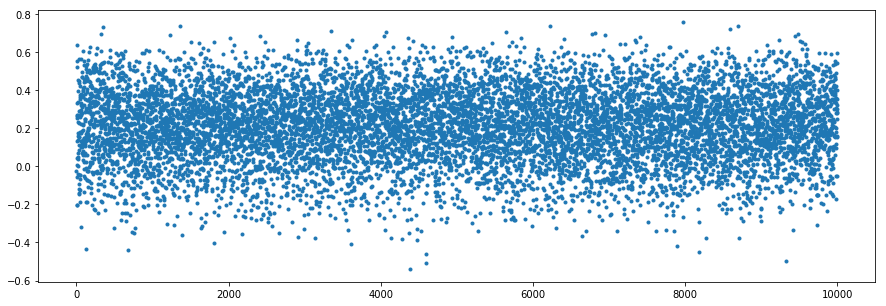

In [29]:
d = 100    # Dimensionality.
n = 10000  # Number of samples.
c = 5      # Number of feature communities.

# Data matrix, structured in communities (feature-wise).
X = np.random.normal(0, 1, (n, d)).astype(np.float32)
X += np.linspace(0, 1, c).repeat(d // c)

# Noisy non-linear target.
w = np.random.normal(0, .02, d)
t = X.dot(w) + np.random.normal(0, .001, n)
t = np.tanh(t)
plt.figure(figsize=(15, 5))
plt.plot(t, '.')

# Classification.
y = np.ones(t.shape, dtype=np.uint8)
y[t > t.mean() + 0.4 * t.std()] = 0
y[t < t.mean() - 0.4 * t.std()] = 2
print('Class imbalance: ', np.unique(y, return_counts=True)[1])

Then split this dataset into training, validation and testing sets.

In [31]:
n_train = n // 2
n_val = n // 10

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

print(X_train)
print(X_train.shape)
print(type(X_train[0]))

[[ 0.31974614 -0.00888791  1.5986431  ...  2.097554    1.3388431
   0.31126958]
 [ 0.11780137  0.5367903   0.21920699 ...  0.06668168 -0.07889569
   0.48715258]
 [ 1.9367204  -0.40496418 -1.5658033  ...  1.7081873  -0.5209187
   0.47765243]
 ...
 [ 1.6455308   1.3537914  -1.4042853  ...  1.5425229   0.4980263
  -0.51155317]
 [ 1.251015    0.9739352   0.06400393 ...  2.1694508  -1.1413615
  -0.02848363]
 [-0.5789312   1.2705636  -0.09071763 ...  2.3734872   2.901114
   0.5022236 ]]
(5000, 100)
<class 'numpy.ndarray'>


# 2 Graph

The second thing we need is a **graph between features**, i.e. an adjacency matrix $A \in \mathbb{R}^{d_x \times d_x}$.
Structuring data with graphs is very flexible: it can accomodate both structured and unstructured data.
1. **Structured data**.
    1. The data is structured by an Euclidean domain, e.g. $x_i$ represents an image, a sound or a video. We can use a classical ConvNet with 1D, 2D or 3D convolutions or a graph ConvNet with a line or grid graph (however losing the orientation).
    2. The data is structured by a graph, e.g. the data lies on a transportation, energy, brain or social network.
2. **Unstructured data**. We could use a fully connected network, but the learning and computational complexities are gonna be large. An alternative is to construct a sparse similarity graph between features (or between samples) and use a graph ConvNet, effectively structuring the data and drastically reducing the number of parameters through weight sharing. As for classical ConvNets, the number of parameters are independent of the input size.

There are many ways, supervised or unsupervised, to construct a graph given some data. And better the graph, better the performance ! For this example we'll define the adjacency matrix as a simple similarity measure between features. Below are the choices one has to make when constructing such a graph.
1. The distance function. We'll use the Euclidean distance $d_{ij} = \|x_i - x_j\|_2$.
2. The kernel. We'll use the Gaussian kernel $a_{ij} = \exp(d_{ij}^2 / \sigma^2)$.
3. The type of graph. We'll use a $k$ nearest neigbors (kNN) graph.

In [23]:
dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)
print(A.type())
assert A.shape == (d, d)
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.spy(A, markersize=2, color='black');

AttributeError: type not found

To be able to pool graph signals, we need first to coarsen the graph, i.e. to find which vertices to group together. At the end we'll have multiple graphs, like a pyramid, each at one level of resolution. The finest graph is where the input data lies, the coarsest graph is where the data at the output of the graph convolutional layers lie. That data, of reduced spatial dimensionality, can then be fed to a fully connected layer.

The parameter here is the number of times to coarsen the graph. Each coarsening approximately reduces the size of the graph by a factor two. Thus if you want a pooling of size 4 in the first layer followed by a pooling of size 2 in the second, you'll need to coarsen $\log_2(4+2) = 3$ times.

After coarsening we rearrange the vertices (and add fake vertices) such that pooling a graph signal is analog to pooling a 1D signal. See the [paper] for details.

[paper]: https://arxiv.org/abs/1606.09375

In [8]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)
print(len(graphs))
X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 112 nodes (12 added),|E| = 672 edges
Layer 1: M_1 = |V| = 56 nodes (5 added),|E| = 325 edges
Layer 2: M_2 = |V| = 28 nodes (2 added),|E| = 110 edges
Layer 3: M_3 = |V| = 14 nodes (0 added),|E| = 42 edges
4


We finally need to compute the graph Laplacian $L$ for each of our graphs (the original and the coarsened versions), defined by their adjacency matrices $A$. The sole parameter here is the type of Laplacian, e.g. the combinatorial Laplacian, the normalized Laplacian or the random walk Laplacian.

(112, 112)


/home/anesterov/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


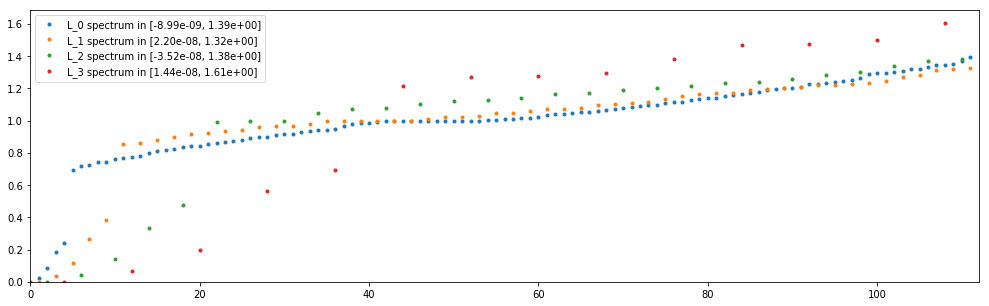

In [34]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
print(L[0].shape)
graph.plot_spectrum(L)

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [13]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 100
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [35]:
print(X_train.shape)
print(y_train.shape)
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

(5000, 100)
(5000,)
NN architecture
  input: M_0 = 112
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 112 * 32 / 4 = 896
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 28 * 64 / 2 = 896
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 896 * 512 = 458752
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 3
    weights: M_3 * M_4 = 512 * 3 = 1536
    biases: M_4 = 3


ValueError: Cannot feed value of shape (100, 100) for Tensor 'inputs/data:0', which has shape '(100, 112)'

# 4 Evaluation

We often want to monitor:
1. The convergence, i.e. the training loss and the classification accuracy on the validation set.
2. The performance, i.e. the classification accuracy on the testing set (to be compared with the training set accuracy to spot overfitting).

The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

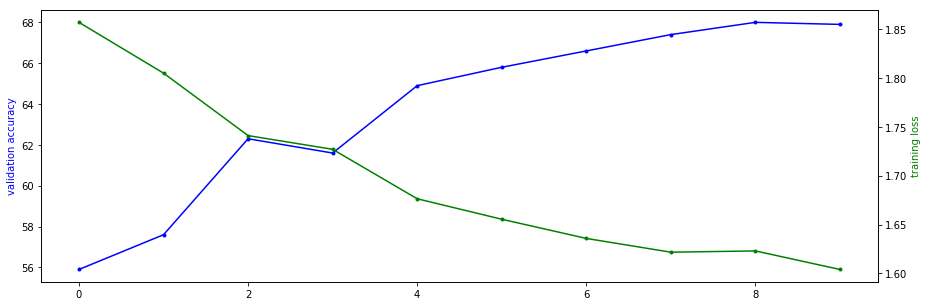

In [16]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [17]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 46.63 ms


In [18]:
res = model.evaluate(X_test, y_test)
print(res[0])

W0715 20:17:47.779380 140318762731328 deprecation.py:323] From /home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


accuracy: 65.10 (2604 / 4000), f1 (weighted): 61.76, loss: 1.62e+00
time: 2s (wall 1s)
